In [201]:
import os
import tensorflow as tf
import glob
import pathlib
from tensorflow import keras
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.python.keras.layers import Dense
from tensorflow.keras.models import Model

In [202]:
train="../test_sample/train"
test="../test_sample/test"
valid="../test_sample/valid"

In [203]:
def process(data):
    path=pathlib.Path(data)#converting the dtring to path
    filepaths=list(path.glob(r"*/*.jpg"))#Going through all the subpaths
    labels=list(map(lambda x: os.path.split(os.path.split(x)[0])[1],filepaths))#Separating the label from filepath and storing it
    df1=pd.Series(filepaths,name='filepaths').astype(str)
    df2=pd.Series(labels,name='labels')
    df=pd.concat([df1,df2],axis=1)#Making the dataframe
    return df

In [204]:
df_train=process(train)
df_test=process(test)
df_valid=process(valid)

In [205]:
train_labels = df_train.labels.unique()

In [206]:
print(len(df_train.labels.unique()))
len(df_valid.labels.unique())

375


375

In [207]:
df_train=df_train.sample(frac=1).reset_index(drop=True)#Shuffling the dataframe so we can get random bird pictures

In [208]:
duck_df = pd.DataFrame()
for i in range(len(df_train)):
    if ("DUCK" in df_train["filepaths"][i]):
        duck_df = duck_df.append(df_train.loc[i])
        df_train = df_train.drop(i)
print(duck_df)

                                          filepaths           labels
157     ../test_sample/train/HARLEQUIN DUCK/127.jpg   HARLEQUIN DUCK
164          ../test_sample/train/TEAL DUCK/097.jpg        TEAL DUCK
225       ../test_sample/train/STEAMER DUCK/005.jpg     STEAMER DUCK
256       ../test_sample/train/MALLARD DUCK/086.jpg     MALLARD DUCK
373       ../test_sample/train/MALLARD DUCK/120.jpg     MALLARD DUCK
...                                             ...              ...
54533   ../test_sample/train/HARLEQUIN DUCK/117.jpg   HARLEQUIN DUCK
54551     ../test_sample/train/STEAMER DUCK/012.jpg     STEAMER DUCK
54552        ../test_sample/train/WOOD DUCK/099.jpg        WOOD DUCK
54577  ../test_sample/train/RED HEADED DUCK/005.jpg  RED HEADED DUCK
54638        ../test_sample/train/TEAL DUCK/078.jpg        TEAL DUCK

[1029 rows x 2 columns]


In [209]:
df_train=df_train.sample(n = 2000)

In [210]:
df_train = pd.concat([duck_df, df_train]).reset_index(drop=True)

In [211]:
train_labels = df_train.labels.unique()

In [212]:
len(train_labels)

373

In [213]:
df_valid

,filepaths,labels
0,../test_sample/valid/TOWNSENDS WARBLER/2.jpg,TOWNSENDS WARBLER
1,../test_sample/valid/TOWNSENDS WARBLER/3.jpg,TOWNSENDS WARBLER
2,../test_sample/valid/TOWNSENDS WARBLER/4.jpg,TOWNSENDS WARBLER
3,../test_sample/valid/TOWNSENDS WARBLER/5.jpg,TOWNSENDS WARBLER
4,../test_sample/valid/TOWNSENDS WARBLER/1.jpg,TOWNSENDS WARBLER
...,...,...
1870,../test_sample/valid/CREAM COLORED WOODPECKER/...,CREAM COLORED WOODPECKER
1871,../test_sample/valid/CREAM COLORED WOODPECKER/...,CREAM COLORED WOODPECKER
1872,../test_sample/valid/CREAM COLORED WOODPECKER/...,CREAM COLORED WOODPECKER
1873,../test_sample/valid/CREAM COLORED WOODPECKER/...,CREAM COLORED WOODPECKER


In [214]:
print(len(df_train.labels.unique()))
len(df_valid.labels.unique())

373


375

In [215]:
for i in range(len(df_valid)):
  if df_valid['labels'][i] not in train_labels and df_valid['labels'][i] != ("BLACK & YELLOW BROADBILL"):
    df_valid = df_valid.drop(i)

In [216]:
for i in range(len(df_test)):
  if df_test['labels'][i] not in train_labels and df_test['labels'][i] != ("BLACK & YELLOW BROADBILL"):
    df_test = df_test.drop(i)

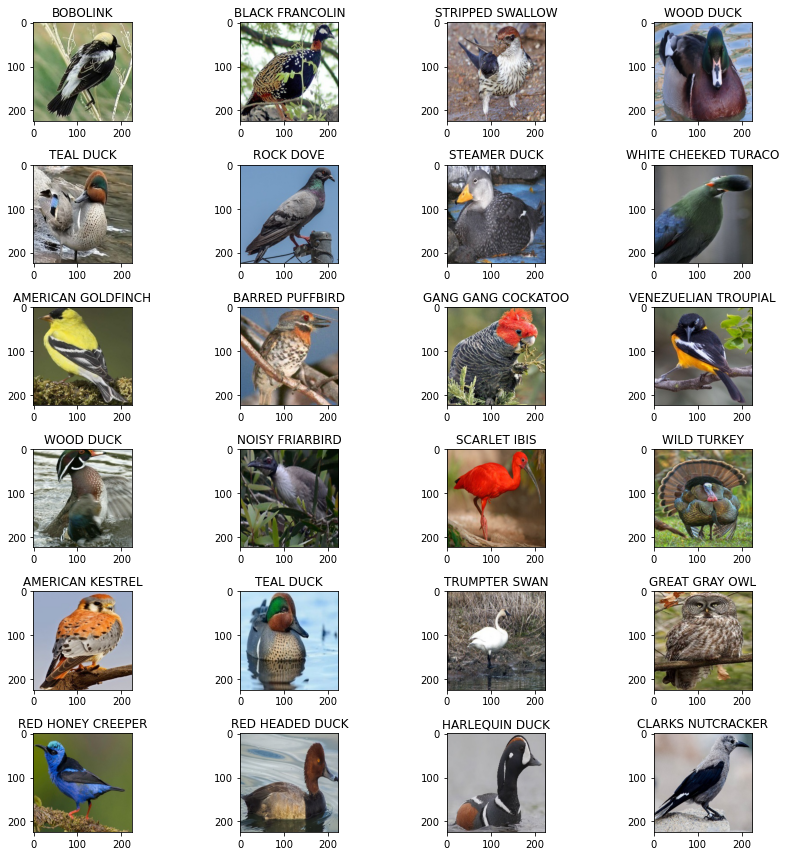

In [217]:
df_train=df_train.sample(frac=1).reset_index(drop=True)#Shuffling the dataframe so we can get random bird pictures
fig,axes=plt.subplots(nrows=6,ncols=4,figsize=(12,12))

for i,ax in enumerate(axes.flat):
    x=plt.imread(df_train['filepaths'][i])#reading the image
    ax.imshow(x)
    ax.set_title(df_train['labels'][i])
plt.tight_layout()    
plt.show()   

In [218]:
train_generator = ImageDataGenerator( preprocessing_function=preprocess_input)
test_generator = ImageDataGenerator( preprocessing_function=preprocess_input)
valid_generator = ImageDataGenerator( preprocessing_function=preprocess_input)

In [219]:
train_image=train_generator.flow_from_dataframe(dataframe=df_train,
                                                x_col='filepaths',
                                                y_col='labels',
                                                target_size=(224,224),
                                                batch_size=16,
                                                subset='training',
                                                random_seed=42)

test_image = test_generator.flow_from_dataframe(
    dataframe=df_test,
    x_col='filepaths',
    y_col='labels',
    target_size=(224,224),
    batch_size=32
)

valid_image = test_generator.flow_from_dataframe(
    dataframe=df_valid,
    x_col='filepaths',
    y_col='labels',
    subset='training',
    target_size=(224,224),
    batch_size=2
)

Found 3029 validated image filenames belonging to 373 classes.
Found 1865 validated image filenames belonging to 373 classes.
Found 1865 validated image filenames belonging to 373 classes.


In [220]:
pretrained_model = ResNet50(
    input_shape=(224,224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False#We don't want to train again th resnet

In [221]:
inputs = pretrained_model.input

x = Dense(120, activation='relu')(pretrained_model.output)
x = Dense(120, activation='relu')(x)#adding some custom layers of our coice

outputs = Dense(373, activation='softmax')(x)
#output choice
model = Model(inputs=inputs, outputs=outputs)

In [222]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
with tf.device('/cpu:0'):
    mo_fit=model.fit(train_image,validation_data=valid_image,epochs=5)

Epoch 1/10
190/190 [==============================] - 141s 737ms/step - loss: 4.7493 - accuracy: 0.1934 - val_loss: 5.1775 - val_accuracy: 0.0552
Epoch 2/10
190/190 [==============================] - 138s 727ms/step - loss: 2.9763 - accuracy: 0.4052 - val_loss: 3.4817 - val_accuracy: 0.2563
Epoch 3/10
190/190 [==============================] - 137s 721ms/step - loss: 1.4317 - accuracy: 0.6499 - val_loss: 2.6340 - val_accuracy: 0.3828
Epoch 4/10
190/190 [==============================] - 139s 731ms/step - loss: 0.6739 - accuracy: 0.8245 - val_loss: 2.3499 - val_accuracy: 0.4381
Epoch 5/10
190/190 [==============================] - 139s 734ms/step - loss: 0.3653 - accuracy: 0.9150 - val_loss: 2.0793 - val_accuracy: 0.5164
Epoch 6/10
 97/190 [==============>...............] - ETA: 36s - loss: 0.1915 - accuracy: 0.9595

In [ ]:
pd.DataFrame(mo_fit.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()
pd.DataFrame(mo_fit.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [ ]:
model.save('../model')

In [ ]:
test_image

In [ ]:
from tensorflow.keras.models import Sequential, save_model, load_model

In [ ]:
save_model(model, '../model')

In [ ]:

predictions = model.predict(test_image)
classes = np.argmax(predictions, axis = 1)
print(len(classes))

In [ ]:
model = load_model('../model', compile = True)

In [ ]:
test_generator.

In [ ]:
import PIL as pil

In [ ]:
img = keras.preprocessing.image.load_img('../test_sample/testing_duck.jpg')

In [ ]:
from resizeimage import resizeimage

In [ ]:
img = resizeimage.resize_cover(img, [224,224])

In [ ]:
img = keras.preprocessing.image.img_to_array(image)
print(img)
print(img.shape)
img.shape[:2]

In [ ]:
from skimage.transform import resize
img = np.expand_dims(img, axis=0)

In [ ]:
prediction = model.predict(img)

In [ ]:
classes = np.argmax(prediction, axis = 1)
print(classes)

In [ ]:
print(df_train["labels"][234])

In [ ]:
print(len(prediction[0]))

In [ ]:
print(df_train["labels"].unique()[235])

In [ ]:
classes  = train_image.class_indices

In [ ]:
classes

In [ ]:
classes = train_image.class_indices
classes_list = classes.keys()
classes_list[0]

In [ ]:
ducks = ['HARLEQUIN DUCK','MALLARD DUCK','MANDRIN DUCK','RED HEADED DUCK','STEAMER DUCK','TEAL DUCK','WOOD DUCK']
model = load_model('../model2', compile = True)
img = keras.preprocessing.image.load_img('../test_sample/testing_duck.jpg')
img = resizeimage.resize_cover(img, [224,224])
img = keras.preprocessing.image.img_to_array(image)
img = np.expand_dims(img, axis=0)
prediction = model.predict(img)
result = np.argmax(prediction, axis = 1)
classes = {'ABBOTTS BABBLER': 0,
 'ABBOTTS BOOBY': 1,
 'ABYSSINIAN GROUND HORNBILL': 2,
 'AFRICAN CROWNED CRANE': 3,
 'AFRICAN EMERALD CUCKOO': 4,
 'AFRICAN FIREFINCH': 5,
 'AFRICAN OYSTER CATCHER': 6,
 'ALBATROSS': 7,
 'ALBERTS TOWHEE': 8,
 'ALEXANDRINE PARAKEET': 9,
 'ALPINE CHOUGH': 10,
 'ALTAMIRA YELLOWTHROAT': 11,
 'AMERICAN AVOCET': 12,
 'AMERICAN BITTERN': 13,
 'AMERICAN COOT': 14,
 'AMERICAN GOLDFINCH': 15,
 'AMERICAN KESTREL': 16,
 'AMERICAN PIPIT': 17,
 'AMERICAN REDSTART': 18,
 'AMETHYST WOODSTAR': 19,
 'ANDEAN GOOSE': 20,
 'ANDEAN LAPWING': 21,
 'ANDEAN SISKIN': 22,
 'ANHINGA': 23,
 'ANIANIAU': 24,
 'ANNAS HUMMINGBIRD': 25,
 'ANTBIRD': 26,
 'ANTILLEAN EUPHONIA': 27,
 'APAPANE': 28,
 'APOSTLEBIRD': 29,
 'ARARIPE MANAKIN': 30,
 'ASHY THRUSHBIRD': 31,
 'ASIAN CRESTED IBIS': 32,
 'AZURE JAY': 33,
 'AZURE TANAGER': 34,
 'AZURE TIT': 35,
 'BAIKAL TEAL': 36,
 'BALD EAGLE': 37,
 'BALD IBIS': 38,
 'BALI STARLING': 39,
 'BALTIMORE ORIOLE': 40,
 'BANANAQUIT': 41,
 'BAND TAILED GUAN': 42,
 'BANDED BROADBILL': 43,
 'BANDED PITA': 44,
 'BANDED STILT': 45,
 'BARN OWL': 46,
 'BARN SWALLOW': 47,
 'BARRED PUFFBIRD': 48,
 'BARROWS GOLDENEYE': 49,
 'BAY-BREASTED WARBLER': 50,
 'BEARDED BARBET': 51,
 'BEARDED BELLBIRD': 52,
 'BEARDED REEDLING': 53,
 'BELTED KINGFISHER': 54,
 'BIRD OF PARADISE': 55,
 'BLACK & YELLOW  BROADBILL': 56,
 'BLACK BAZA': 57,
 'BLACK COCKATO': 58,
 'BLACK FRANCOLIN': 59,
 'BLACK SKIMMER': 60,
 'BLACK SWAN': 61,
 'BLACK TAIL CRAKE': 62,
 'BLACK THROATED BUSHTIT': 63,
 'BLACK THROATED WARBLER': 64,
 'BLACK VULTURE': 65,
 'BLACK-CAPPED CHICKADEE': 66,
 'BLACK-NECKED GREBE': 67,
 'BLACK-THROATED SPARROW': 68,
 'BLACKBURNIAM WARBLER': 69,
 'BLONDE CRESTED WOODPECKER': 70,
 'BLUE COAU': 71,
 'BLUE GROUSE': 72,
 'BLUE HERON': 73,
 'BLUE THROATED TOUCANET': 74,
 'BOBOLINK': 75,
 'BORNEAN BRISTLEHEAD': 76,
 'BORNEAN LEAFBIRD': 77,
 'BORNEAN PHEASANT': 78,
 'BRANDT CORMARANT': 79,
 'BROWN CREPPER': 80,
 'BROWN NOODY': 81,
 'BROWN THRASHER': 82,
 'BULWERS PHEASANT': 83,
 'BUSH TURKEY': 84,
 'CACTUS WREN': 85,
 'CALIFORNIA CONDOR': 86,
 'CALIFORNIA GULL': 87,
 'CALIFORNIA QUAIL': 88,
 'CANARY': 89,
 'CAPE GLOSSY STARLING': 90,
 'CAPE LONGCLAW': 91,
 'CAPE MAY WARBLER': 92,
 'CAPE ROCK THRUSH': 93,
 'CAPPED HERON': 94,
 'CAPUCHINBIRD': 95,
 'CARMINE BEE-EATER': 96,
 'CASPIAN TERN': 97,
 'CASSOWARY': 98,
 'CEDAR WAXWING': 99,
 'CERULEAN WARBLER': 100,
 'CHARA DE COLLAR': 101,
 'CHATTERING LORY': 102,
 'CHESTNET BELLIED EUPHONIA': 103,
 'CHINESE BAMBOO PARTRIDGE': 104,
 'CHINESE POND HERON': 105,
 'CHIPPING SPARROW': 106,
 'CHUCAO TAPACULO': 107,
 'CHUKAR PARTRIDGE': 108,
 'CINNAMON ATTILA': 109,
 'CINNAMON FLYCATCHER': 110,
 'CINNAMON TEAL': 111,
 'CLARKS NUTCRACKER': 112,
 'COCK OF THE  ROCK': 113,
 'COCKATOO': 114,
 'COLLARED ARACARI': 115,
 'COMMON FIRECREST': 116,
 'COMMON GRACKLE': 117,
 'COMMON HOUSE MARTIN': 118,
 'COMMON IORA': 119,
 'COMMON LOON': 120,
 'COMMON POORWILL': 121,
 'COMMON STARLING': 122,
 'COPPERY TAILED COUCAL': 123,
 'CRAB PLOVER': 124,
 'CRANE HAWK': 125,
 'CREAM COLORED WOODPECKER': 126,
 'CRESTED CARACARA': 127,
 'CRESTED COUA': 128,
 'CRESTED FIREBACK': 129,
 'CRESTED KINGFISHER': 130,
 'CRESTED NUTHATCH': 131,
 'CRESTED OROPENDOLA': 132,
 'CRESTED SHRIKETIT': 133,
 'CRIMSON CHAT': 134,
 'CRIMSON SUNBIRD': 135,
 'CROW': 136,
 'CROWNED PIGEON': 137,
 'CUBAN TODY': 138,
 'CUBAN TROGON': 139,
 'CURL CRESTED ARACURI': 140,
 'D-ARNAUDS BARBET': 141,
 'DARK EYED JUNCO': 142,
 'DEMOISELLE CRANE': 143,
 'DOUBLE BARRED FINCH': 144,
 'DOUBLE BRESTED CORMARANT': 145,
 'DOUBLE EYED FIG PARROT': 146,
 'DOWNY WOODPECKER': 147,
 'EARED PITA': 148,
 'EASTERN BLUEBIRD': 149,
 'EASTERN GOLDEN WEAVER': 150,
 'EASTERN MEADOWLARK': 151,
 'EASTERN ROSELLA': 152,
 'EASTERN TOWEE': 153,
 'ELEGANT TROGON': 154,
 'ELLIOTS  PHEASANT': 155,
 'EMPEROR PENGUIN': 156,
 'EMU': 157,
 'ENGGANO MYNA': 158,
 'EURASIAN GOLDEN ORIOLE': 159,
 'EURASIAN MAGPIE': 160,
 'EVENING GROSBEAK': 161,
 'FAIRY BLUEBIRD': 162,
 'FIRE TAILLED MYZORNIS': 163,
 'FLAME TANAGER': 164,
 'FLAMINGO': 165,
 'FRIGATE': 166,
 'GAMBELS QUAIL': 167,
 'GANG GANG COCKATOO': 168,
 'GILA WOODPECKER': 169,
 'GILDED FLICKER': 170,
 'GLOSSY IBIS': 171,
 'GO AWAY BIRD': 172,
 'GOLD WING WARBLER': 173,
 'GOLDEN CHEEKED WARBLER': 174,
 'GOLDEN CHLOROPHONIA': 175,
 'GOLDEN EAGLE': 176,
 'GOLDEN PHEASANT': 177,
 'GOLDEN PIPIT': 178,
 'GOULDIAN FINCH': 179,
 'GRAY CATBIRD': 180,
 'GRAY KINGBIRD': 181,
 'GRAY PARTRIDGE': 182,
 'GREAT GRAY OWL': 183,
 'GREAT KISKADEE': 184,
 'GREAT POTOO': 185,
 'GREATOR SAGE GROUSE': 186,
 'GREEN BROADBILL': 187,
 'GREEN JAY': 188,
 'GREEN MAGPIE': 189,
 'GREY PLOVER': 190,
 'GROVED BILLED ANI': 191,
 'GUINEA TURACO': 192,
 'GUINEAFOWL': 193,
 'GYRFALCON': 194,
 'HARLEQUIN DUCK': 195,
 'HARPY EAGLE': 196,
 'HAWAIIAN GOOSE': 197,
 'HELMET VANGA': 198,
 'HIMALAYAN MONAL': 199,
 'HOATZIN': 200,
 'HOODED MERGANSER': 201,
 'HOOPOES': 202,
 'HORNBILL': 203,
 'HORNED GUAN': 204,
 'HORNED LARK': 205,
 'HORNED SUNGEM': 206,
 'HOUSE FINCH': 207,
 'HOUSE SPARROW': 208,
 'HYACINTH MACAW': 209,
 'IMPERIAL SHAQ': 210,
 'INCA TERN': 211,
 'INDIAN BUSTARD': 212,
 'INDIAN PITTA': 213,
 'INDIAN ROLLER': 214,
 'INDIGO BUNTING': 215,
 'IWI': 216,
 'JABIRU': 217,
 'JAVA SPARROW': 218,
 'KAGU': 219,
 'KAKAPO': 220,
 'KILLDEAR': 221,
 'KING VULTURE': 222,
 'KIWI': 223,
 'KOOKABURRA': 224,
 'LARK BUNTING': 225,
 'LAZULI BUNTING': 226,
 'LILAC ROLLER': 227,
 'LONG-EARED OWL': 228,
 'MAGPIE GOOSE': 229,
 'MALABAR HORNBILL': 230,
 'MALACHITE KINGFISHER': 231,
 'MALAGASY WHITE EYE': 232,
 'MALEO': 233,
 'MALLARD DUCK': 234,
 'MANDRIN DUCK': 235,
 'MANGROVE CUCKOO': 236,
 'MARABOU STORK': 237,
 'MASKED BOOBY': 238,
 'MASKED LAPWING': 239,
 'MIKADO  PHEASANT': 240,
 'MOURNING DOVE': 241,
 'MYNA': 242,
 'NICOBAR PIGEON': 243,
 'NOISY FRIARBIRD': 244,
 'NORTHERN CARDINAL': 245,
 'NORTHERN FLICKER': 246,
 'NORTHERN FULMAR': 247,
 'NORTHERN GANNET': 248,
 'NORTHERN GOSHAWK': 249,
 'NORTHERN JACANA': 250,
 'NORTHERN MOCKINGBIRD': 251,
 'NORTHERN PARULA': 252,
 'NORTHERN RED BISHOP': 253,
 'NORTHERN SHOVELER': 254,
 'OCELLATED TURKEY': 255,
 'OKINAWA RAIL': 256,
 'ORANGE BRESTED BUNTING': 257,
 'ORIENTAL BAY OWL': 258,
 'OSPREY': 259,
 'OSTRICH': 260,
 'OVENBIRD': 261,
 'OYSTER CATCHER': 262,
 'PAINTED BUNTING': 263,
 'PALILA': 264,
 'PARADISE TANAGER': 265,
 'PARAKETT  AKULET': 266,
 'PARUS MAJOR': 267,
 'PATAGONIAN SIERRA FINCH': 268,
 'PEACOCK': 269,
 'PELICAN': 270,
 'PEREGRINE FALCON': 271,
 'PHILIPPINE EAGLE': 272,
 'PINK ROBIN': 273,
 'POMARINE JAEGER': 274,
 'PUFFIN': 275,
 'PURPLE FINCH': 276,
 'PURPLE GALLINULE': 277,
 'PURPLE MARTIN': 278,
 'PURPLE SWAMPHEN': 279,
 'PYGMY KINGFISHER': 280,
 'QUETZAL': 281,
 'RAINBOW LORIKEET': 282,
 'RAZORBILL': 283,
 'RED BEARDED BEE EATER': 284,
 'RED BELLIED PITTA': 285,
 'RED BROWED FINCH': 286,
 'RED FACED CORMORANT': 287,
 'RED FACED WARBLER': 288,
 'RED FODY': 289,
 'RED HEADED DUCK': 290,
 'RED HEADED WOODPECKER': 291,
 'RED HONEY CREEPER': 292,
 'RED NAPED TROGON': 293,
 'RED TAILED HAWK': 294,
 'RED TAILED THRUSH': 295,
 'RED WINGED BLACKBIRD': 296,
 'RED WISKERED BULBUL': 297,
 'REGENT BOWERBIRD': 298,
 'RING-NECKED PHEASANT': 299,
 'ROADRUNNER': 300,
 'ROBIN': 301,
 'ROCK DOVE': 302,
 'ROSY FACED LOVEBIRD': 303,
 'ROUGH LEG BUZZARD': 304,
 'ROYAL FLYCATCHER': 305,
 'RUBY THROATED HUMMINGBIRD': 306,
 'RUDY KINGFISHER': 307,
 'RUFOUS KINGFISHER': 308,
 'RUFUOS MOTMOT': 309,
 'SAMATRAN THRUSH': 310,
 'SAND MARTIN': 311,
 'SANDHILL CRANE': 312,
 'SATYR TRAGOPAN': 313,
 'SCARLET CROWNED FRUIT DOVE': 314,
 'SCARLET IBIS': 315,
 'SCARLET MACAW': 316,
 'SCARLET TANAGER': 317,
 'SHOEBILL': 318,
 'SHORT BILLED DOWITCHER': 319,
 'SMITHS LONGSPUR': 320,
 'SNOWY EGRET': 321,
 'SNOWY OWL': 322,
 'SORA': 323,
 'SPANGLED COTINGA': 324,
 'SPLENDID WREN': 325,
 'SPOON BILED SANDPIPER': 326,
 'SPOONBILL': 327,
 'SPOTTED CATBIRD': 328,
 'SRI LANKA BLUE MAGPIE': 329,
 'STEAMER DUCK': 330,
 'STORK BILLED KINGFISHER': 331,
 'STRAWBERRY FINCH': 332,
 'STRIPED OWL': 333,
 'STRIPPED MANAKIN': 334,
 'STRIPPED SWALLOW': 335,
 'SUPERB STARLING': 336,
 'SWINHOES PHEASANT': 337,
 'TAILORBIRD': 338,
 'TAIWAN MAGPIE': 339,
 'TAKAHE': 340,
 'TASMANIAN HEN': 341,
 'TEAL DUCK': 342,
 'TIT MOUSE': 343,
 'TOUCHAN': 344,
 'TOWNSENDS WARBLER': 345,
 'TREE SWALLOW': 346,
 'TROPICAL KINGBIRD': 347,
 'TRUMPTER SWAN': 348,
 'TURKEY VULTURE': 349,
 'TURQUOISE MOTMOT': 350,
 'UMBRELLA BIRD': 351,
 'VARIED THRUSH': 352,
 'VENEZUELIAN TROUPIAL': 353,
 'VERMILION FLYCATHER': 354,
 'VICTORIA CROWNED PIGEON': 355,
 'VIOLET GREEN SWALLOW': 356,
 'VULTURINE GUINEAFOWL': 357,
 'WALL CREAPER': 358,
 'WATTLED CURASSOW': 359,
 'WATTLED LAPWING': 360,
 'WHIMBREL': 361,
 'WHITE BROWED CRAKE': 362,
 'WHITE CHEEKED TURACO': 363,
 'WHITE NECKED RAVEN': 364,
 'WHITE TAILED TROPIC': 365,
 'WHITE THROATED BEE EATER': 366,
 'WILD TURKEY': 367,
 'WILSONS BIRD OF PARADISE': 368,
 'WOOD DUCK': 369,
 'YELLOW BELLIED FLOWERPECKER': 370,
 'YELLOW CACIQUE': 371,
 'YELLOW HEADED BLACKBIRD': 372}
for i in ducks:
    if classes[i] == result:
        return(i)
return("Not a duck")